In [11]:
from tkinter import filedialog
from tkinter import Tk
import pandas as pd

root = Tk()
root.withdraw()

# Read data
csv_file_path = filedialog.askopenfilename(title="Select Real-Data file", filetypes=(("CSV files", "*.csv"), ("All files", "*.*")))
Setting_File_path = filedialog.askopenfilename(title="Select Setting-file", filetypes=(("Excel files", "*.xlsx"), ("All files", "*.*")))
Sim_File_path = filedialog.askopenfilename(title="Select Sim-result file", filetypes=(("CSV files", "*.csv"), ("All files", "*.*")))

# Define data
df_setting = pd.read_excel(Setting_File_path)
feature_vars = df_setting.loc[df_setting['Analysis_List'].notna(), 'Analysis_List'].tolist()
target_variable = df_setting.loc[df_setting['Target_Variable'].notna(), 'Target_Variable'].values[0]

df = pd.read_csv(csv_file_path)
dfsim = pd.read_csv(Sim_File_path)

# Mode check @ Real-Data
mode_data = df["Mode"]
unique_modes = mode_data.drop_duplicates().tolist()
print("Unique Modes:", unique_modes)


Unique Modes: ['USHWY', 'JC08', 'LA4', 'US06', '2WFf3kai', '2wfF4', 'VHmn', '2FJ']


In [12]:
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np
import math

def prepare_kfold_data(df, target_var, feature_vars):
    X = df[feature_vars]
    y = df[target_var]
    return X, y


def train_xgboost_optuna(X_train, y_train):
    def objective(trial):
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2)
        max_depth = trial.suggest_int('max_depth', 3, 5)
        
        model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, objective='reg:squarederror')
        return mean_squared_error(y_train, model.fit(X_train, y_train).predict(X_train))
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)
    
    best_params = study.best_params
    best_model = XGBRegressor(**best_params, objective='reg:squarederror')
    best_model.fit(X_train, y_train)
    
    y_train_pred = best_model.predict(X_train)
    return best_model, best_params, y_train_pred


def evaluate_model(model, X_test, y_test, X_train, y_train):
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    rmse_test = math.sqrt(mean_squared_error(y_test, y_pred))
    r2_test = r2_score(y_test, y_pred)
    rmse_train = math.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)
    return rmse_test, r2_test, y_pred, rmse_train, r2_train, y_train_pred


def kfold_xgboost_training(X, y):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    results_df = pd.DataFrame(columns=["Iteration", "Best_Params", "RMSE", "R2"])
    predictions = []

    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model, params, y_train_pred = train_xgboost_optuna(X_train, y_train)
        rmse_test, r2_test, y_pred, rmse_train, r2_train, y_train_pred = evaluate_model(model, X_test, y_test, X_train, y_train)
        
        results_df.loc[i] = [i+1, params, rmse_test, r2_test]
        predictions.append({"y_test": y_test, "y_pred": y_pred, "y_train": y_train, "y_train_pred": y_train_pred})
        
        print(f"Iteration {i+1} completed.")

    print(results_df.style.highlight_max(color = 'lightgreen', axis = 0))
    return predictions

if __name__ == "__main__":
    X, y = prepare_kfold_data(df, target_variable, feature_vars)
    predictions = kfold_xgboost_training(X, y)


[I 2023-09-04 14:32:40,375] A new study created in memory with name: no-name-b16e467b-84e9-4c66-a65a-67ef280691d7
[I 2023-09-04 14:32:43,183] Trial 0 finished with value: 3.686096587396446 and parameters: {'n_estimators': 192, 'learning_rate': 0.08444272102229372, 'max_depth': 3}. Best is trial 0 with value: 3.686096587396446.
[I 2023-09-04 14:32:45,231] Trial 1 finished with value: 5.072004832502636 and parameters: {'n_estimators': 126, 'learning_rate': 0.04916621806758075, 'max_depth': 3}. Best is trial 0 with value: 3.686096587396446.
[I 2023-09-04 14:32:49,034] Trial 2 finished with value: 2.7354883356032955 and parameters: {'n_estimators': 122, 'learning_rate': 0.11747717901389056, 'max_depth': 4}. Best is trial 2 with value: 2.7354883356032955.
[I 2023-09-04 14:32:50,817] Trial 3 finished with value: 2.245920747691851 and parameters: {'n_estimators': 60, 'learning_rate': 0.16798789909241565, 'max_depth': 5}. Best is trial 3 with value: 2.245920747691851.
[I 2023-09-04 14:32:51,88

Iteration 1 completed.


[I 2023-09-04 14:35:17,426] Trial 0 finished with value: 2.327794045336703 and parameters: {'n_estimators': 82, 'learning_rate': 0.10664318158994467, 'max_depth': 5}. Best is trial 0 with value: 2.327794045336703.
[I 2023-09-04 14:35:19,513] Trial 1 finished with value: 3.2843345402321433 and parameters: {'n_estimators': 180, 'learning_rate': 0.13065833741250982, 'max_depth': 3}. Best is trial 0 with value: 2.327794045336703.
[I 2023-09-04 14:35:21,787] Trial 2 finished with value: 281.6928106271289 and parameters: {'n_estimators': 79, 'learning_rate': 0.02187882261240305, 'max_depth': 3}. Best is trial 0 with value: 2.327794045336703.
[I 2023-09-04 14:35:23,437] Trial 3 finished with value: 3.100670147025637 and parameters: {'n_estimators': 116, 'learning_rate': 0.09374498264197519, 'max_depth': 4}. Best is trial 0 with value: 2.327794045336703.
[I 2023-09-04 14:35:25,493] Trial 4 finished with value: 3.4972268643087183 and parameters: {'n_estimators': 181, 'learning_rate': 0.10886363

Iteration 2 completed.


[I 2023-09-04 14:37:34,868] Trial 0 finished with value: 5.158551256135314 and parameters: {'n_estimators': 58, 'learning_rate': 0.0982125520053439, 'max_depth': 3}. Best is trial 0 with value: 5.158551256135314.
[I 2023-09-04 14:37:38,059] Trial 1 finished with value: 1.3183247716846038 and parameters: {'n_estimators': 156, 'learning_rate': 0.17354801719875082, 'max_depth': 5}. Best is trial 1 with value: 1.3183247716846038.
[I 2023-09-04 14:37:39,646] Trial 2 finished with value: 15.551708651280007 and parameters: {'n_estimators': 114, 'learning_rate': 0.029060756897705223, 'max_depth': 4}. Best is trial 1 with value: 1.3183247716846038.
[I 2023-09-04 14:37:42,196] Trial 3 finished with value: 2.993638316801609 and parameters: {'n_estimators': 116, 'learning_rate': 0.04573452723350462, 'max_depth': 5}. Best is trial 1 with value: 1.3183247716846038.
[I 2023-09-04 14:37:43,828] Trial 4 finished with value: 2.7166618768053294 and parameters: {'n_estimators': 122, 'learning_rate': 0.131

Iteration 3 completed.


[I 2023-09-04 14:39:54,967] Trial 0 finished with value: 1.4696011460982283 and parameters: {'n_estimators': 129, 'learning_rate': 0.1803850484565768, 'max_depth': 5}. Best is trial 0 with value: 1.4696011460982283.
[I 2023-09-04 14:39:56,399] Trial 1 finished with value: 2.5140567840934875 and parameters: {'n_estimators': 74, 'learning_rate': 0.0967978464900573, 'max_depth': 5}. Best is trial 0 with value: 1.4696011460982283.
[I 2023-09-04 14:39:58,841] Trial 2 finished with value: 2.2495599141025346 and parameters: {'n_estimators': 175, 'learning_rate': 0.13304464717383013, 'max_depth': 4}. Best is trial 0 with value: 1.4696011460982283.
[I 2023-09-04 14:40:00,700] Trial 3 finished with value: 2.520819463219366 and parameters: {'n_estimators': 103, 'learning_rate': 0.06663672131357645, 'max_depth': 5}. Best is trial 0 with value: 1.4696011460982283.
[I 2023-09-04 14:40:02,333] Trial 4 finished with value: 3.3560202507905426 and parameters: {'n_estimators': 166, 'learning_rate': 0.128

Iteration 4 completed.


[I 2023-09-04 14:42:13,170] Trial 0 finished with value: 2.2837673034668544 and parameters: {'n_estimators': 175, 'learning_rate': 0.05581512572310346, 'max_depth': 5}. Best is trial 0 with value: 2.2837673034668544.
[I 2023-09-04 14:42:14,856] Trial 1 finished with value: 3.5962177970746487 and parameters: {'n_estimators': 162, 'learning_rate': 0.12014818546342017, 'max_depth': 3}. Best is trial 0 with value: 2.2837673034668544.
[I 2023-09-04 14:42:15,540] Trial 2 finished with value: 4.739168563985129 and parameters: {'n_estimators': 54, 'learning_rate': 0.08544067496263943, 'max_depth': 4}. Best is trial 0 with value: 2.2837673034668544.
[I 2023-09-04 14:42:16,347] Trial 3 finished with value: 37.139628405554035 and parameters: {'n_estimators': 76, 'learning_rate': 0.03685722805517345, 'max_depth': 3}. Best is trial 0 with value: 2.2837673034668544.
[I 2023-09-04 14:42:17,395] Trial 4 finished with value: 2.838550702138167 and parameters: {'n_estimators': 86, 'learning_rate': 0.1588

Iteration 5 completed.


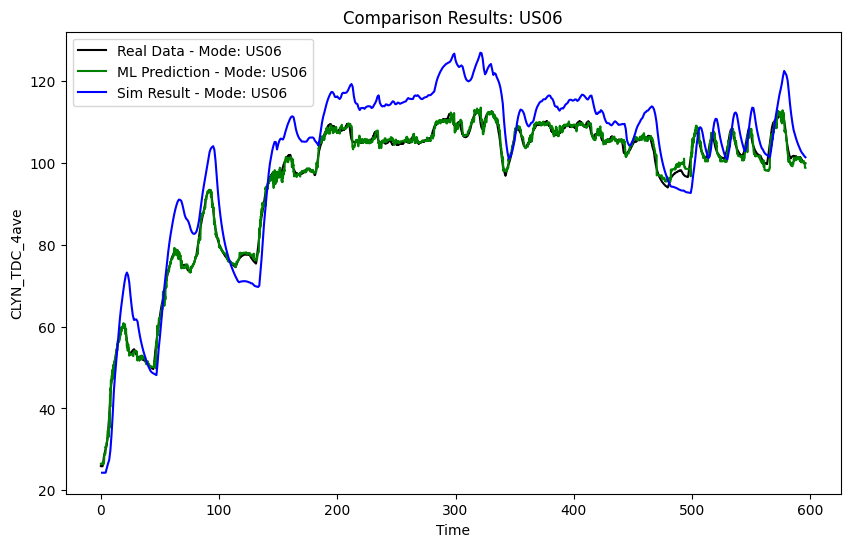

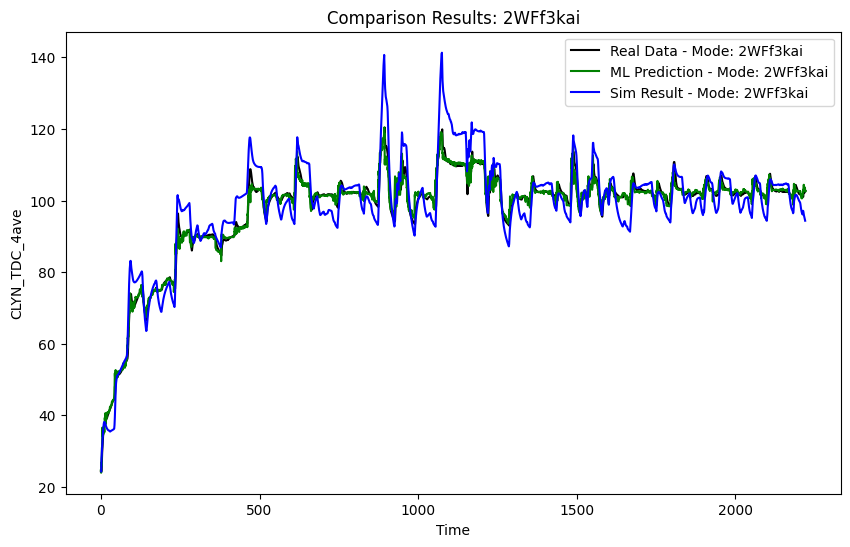

In [13]:
def plot_predictions(best_model, df, dfsim, feature_vars, target_variable, unique_modes):
    for mode in unique_modes:
        plt.figure(figsize=(10, 6))
        
        filtered_df = df[df['Mode'] == mode]
        filtered_dfsim = dfsim[dfsim['Mode'] == mode]
        
        X = filtered_df[feature_vars]
        real_time_data = filtered_df["time"]
        y_pred = best_model.predict(X)
        
        y_real = filtered_df[target_variable]
        
        sim_time_data = filtered_dfsim["time"]
        sim_target = filtered_dfsim[target_variable]
        
        plt.plot(real_time_data, y_real, label=f'Real Data - Mode: {mode}', color='black')
        plt.plot(real_time_data, y_pred, label=f'ML Prediction - Mode: {mode}', color='green')
        plt.plot(sim_time_data, sim_target, label=f'Sim Result - Mode: {mode}', color='blue')
        
        plt.xlabel('Time')
        plt.ylabel(target_variable)
        plt.title(f"Comparison Results: {mode}")
        plt.legend()
        plt.show()

plot_predictions(best_model, df, dfsim, feature_vars, target_variable, unique_modes)


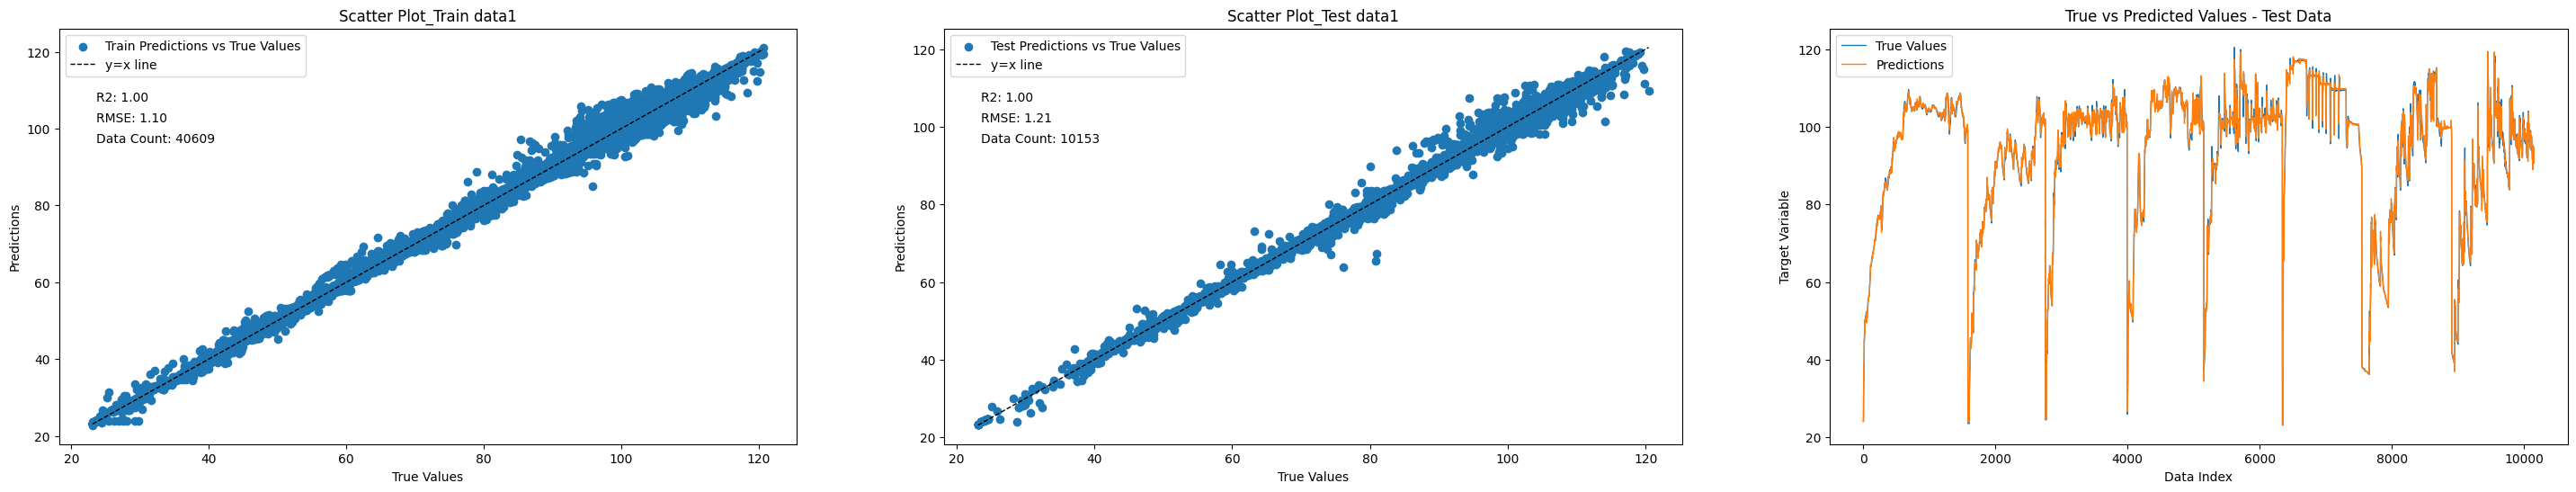

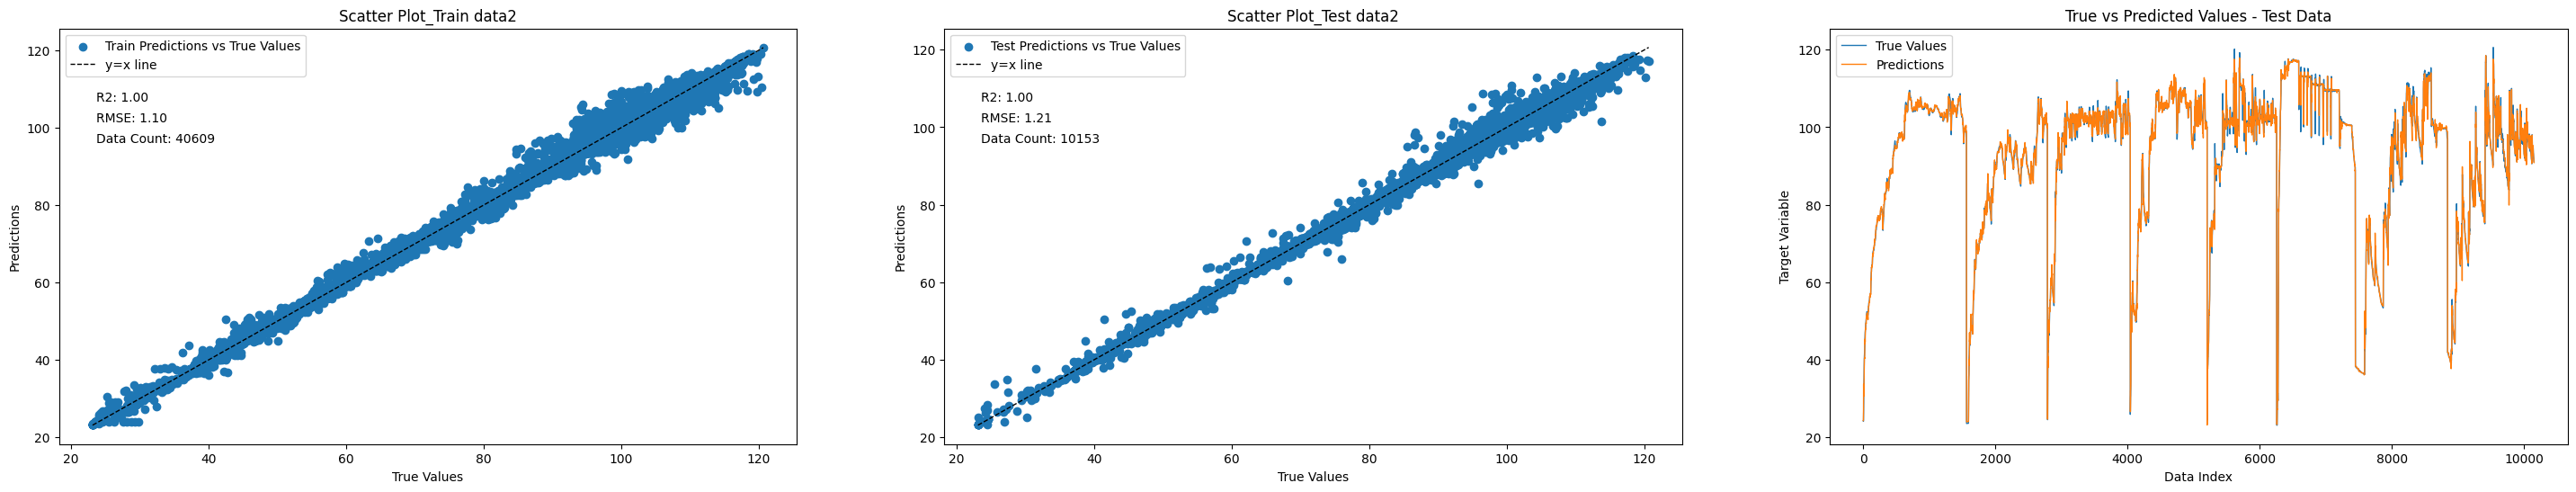

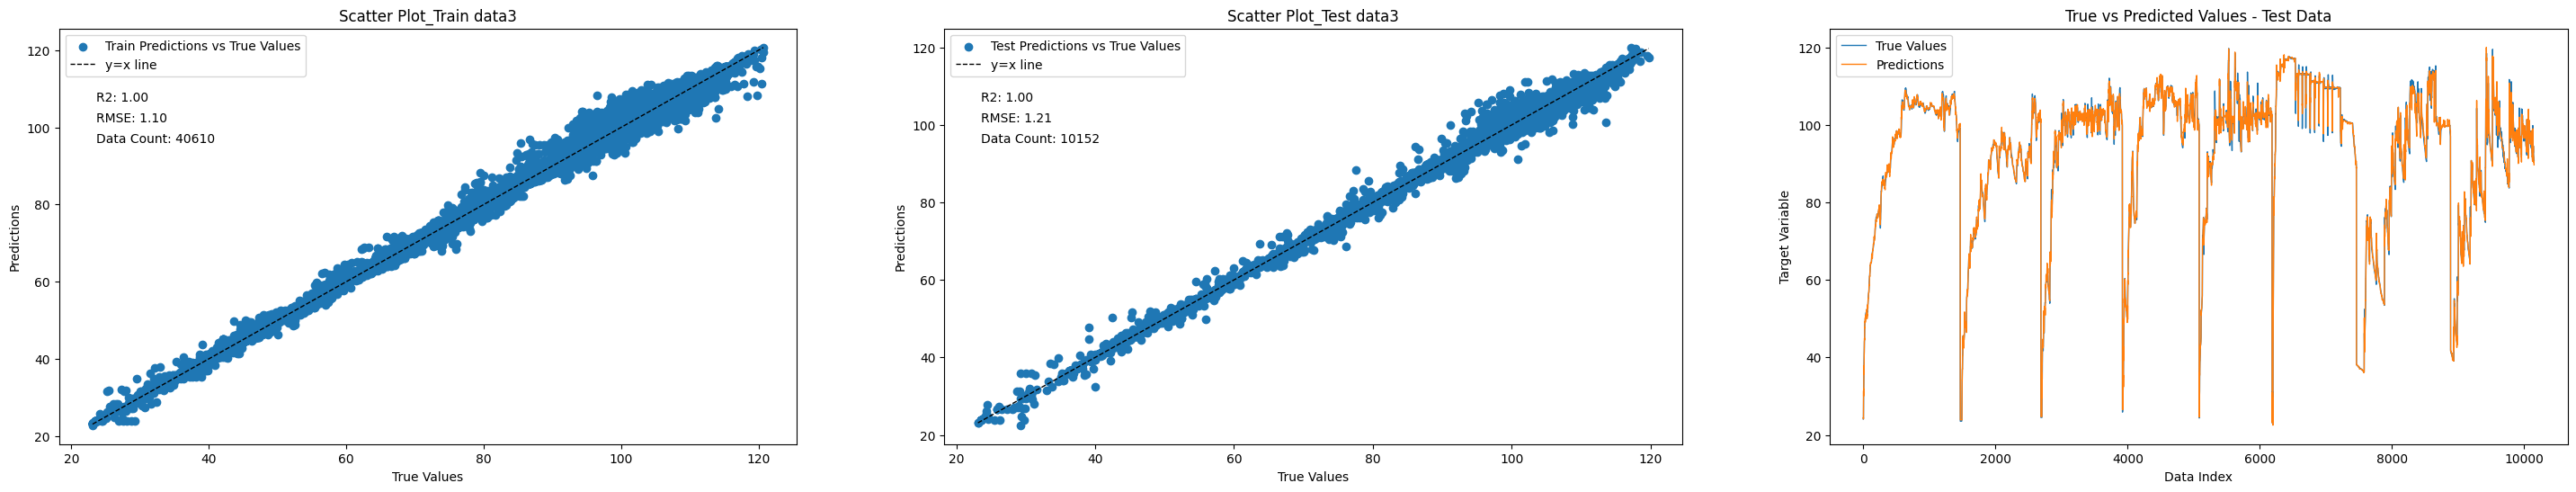

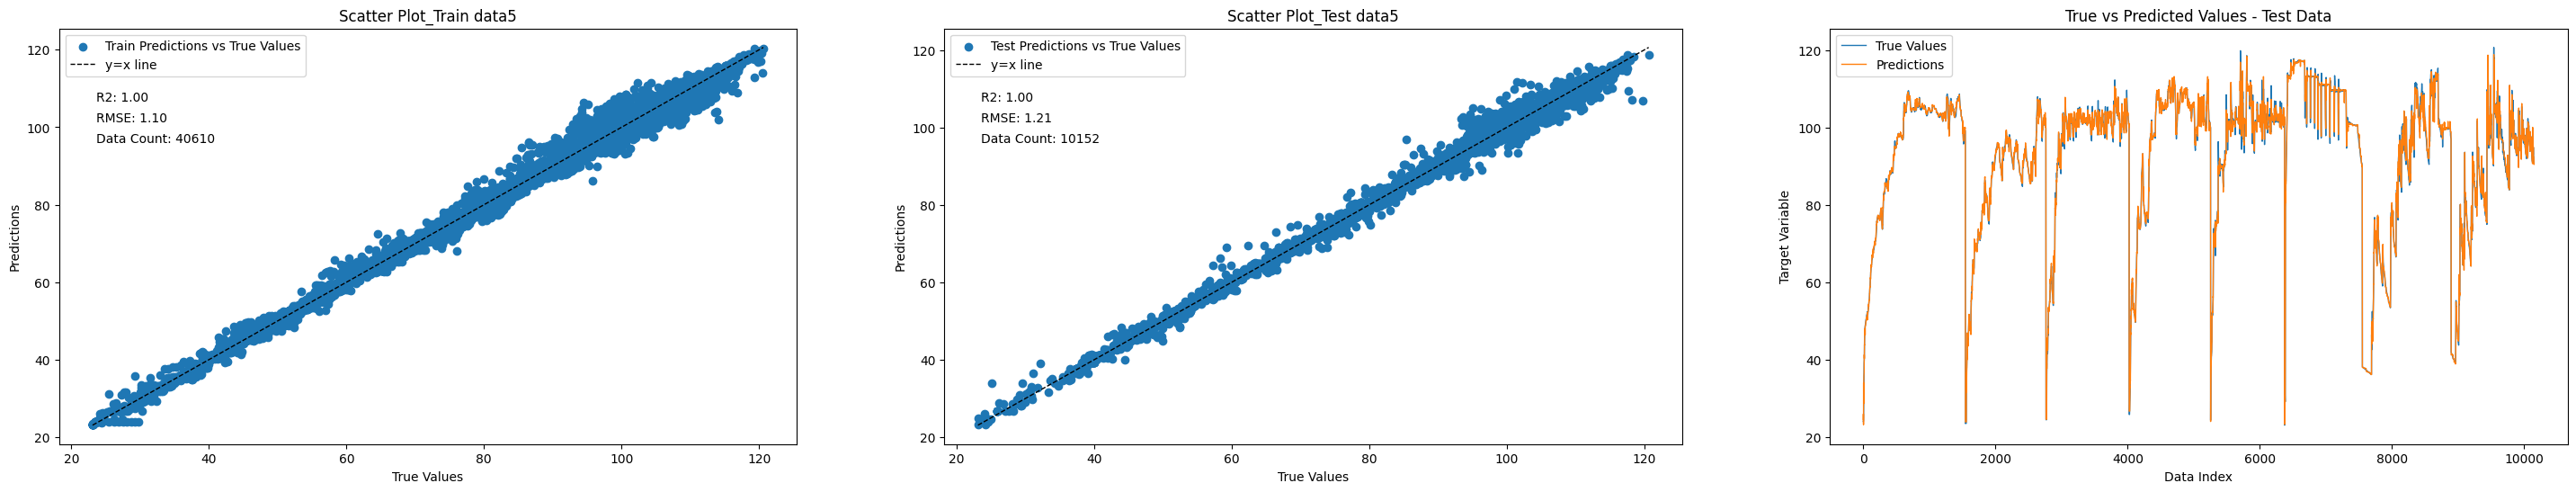

In [15]:
for i, pred in enumerate(predictions):
    y_test = pred["y_test"]
    y_pred = pred["y_pred"]
    y_train = pred["y_train"]
    y_train_pred = pred["y_train_pred"]
    
    # データ数を取得
    n_train = len(y_train)
    n_test = len(y_test)
    
    fig, axs = plt.subplots(1, 3, figsize=(36, 6))
    
    # 訓練データのScatterプロット
    axs[0].scatter(y_train, y_train_pred, label='Train Prediction vs True Value')
    axs[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=1, label='y=x line')
    axs[0].set_xlabel('True Value')
    axs[0].set_ylabel('Prediction')
    axs[0].set_title(f'Scatter Plot_Train data{i+1}')
    axs[0].legend()
    axs[0].text(0.05, 0.85, f'R2: {r2_train:.2f}', transform=axs[0].transAxes, verticalalignment='top')
    axs[0].text(0.05, 0.80, f'RMSE: {rmse_train:.2f}', transform=axs[0].transAxes, verticalalignment='top')
    axs[0].text(0.05, 0.75, f'Data Count: {n_train}', transform=axs[0].transAxes, verticalalignment='top')

    # テストデータのScatterプロット
    axs[1].scatter(y_test, y_pred, label='Test Prediction vs True Value')
    axs[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, label='y=x line')
    axs[1].set_xlabel('True Value')
    axs[1].set_ylabel('Prediction')
    axs[1].set_title(f'Scatter Plot_Test data{i+1}')
    axs[1].legend()
    axs[1].text(0.05, 0.85, f'R2: {r2_test:.2f}', transform=axs[1].transAxes, verticalalignment='top')
    axs[1].text(0.05, 0.80, f'RMSE: {rmse_test:.2f}', transform=axs[1].transAxes, verticalalignment='top')
    axs[1].text(0.05, 0.75, f'Data Count: {n_test}', transform=axs[1].transAxes, verticalalignment='top') 
    
    # True vs Prediction のプロット
    axs[2].plot(range(len(y_test)), y_test, label='True Value', lw=1)
    axs[2].plot(range(len(y_test)), y_pred, label='Prediction', lw=1)
    axs[2].set_xlabel('Data Index')
    axs[2].set_ylabel('Target Variable')
    axs[2].legend()
    axs[2].set_title('True vs Prediction - Test Data')
    
    plt.show()
